# Simulation with ``DSRunner``

@[Tianqiu Zhang](mailto:tianqiuakita@gmail.com) @[Chaoming Wang](mailto:adaduo@outlook.com) @[Xiaoyu Chen](mailto:c-xy17@tsinghua.org.cn)

The convenient simulation interface for dynamical systems in BrainPy is implemented by ``brainpy.dyn.DSRunner``. It can simulate various levels of models including channels, neurons, synapses and systems. In this tutorial, we will introduce how to use ``brainpy.dyn.DSRunner`` in detail.

In [1]:
import brainpy as bp
import brainpy.math as bm

# bm.set_platform('cpu')

In [2]:
bp.__version__

'2.3.0'

## Initializing a DSRunner

Generally, we can initialize a runner for dynamical systems with the format of:
```python
runner = DSRunner(target=instance_of_dynamical_system,
                  inputs=inputs_for_target_DynamicalSystem,
                  fun_inputs=the_functional_inputs,
                  monitors=interested_variables_to_monitor,
                  fun_monitors=monitoring_variables_by_callable_functions,
                  dyn_vars=dynamical_changed_variables,
                  jit=enable_jit_or_not,
                  progress_bar=report_the_running_progress,
                  numpy_mon_after_run=transform_into_numpy_ndarray
                  )
```

In which
- ``target`` specifies the model to be simulated. It must an instance of [brainpy.DynamicalSystem](../apis/auto/simulation/generated/brainpy.simulation.brainobjects.DynamicalSystem.rst).
- ``inputs`` is used to define the input operations for specific variables. It should be the format of `[(target, value, [type, operation])]`, where `target` is the input target, `value` is the input value, `type` is the input type (such as "fix", "iter", "func"), `operation` is the operation for inputs (such as "+", "-", "*", "/", "="). Also, if you want to specify multiple inputs, just give multiple ``(target, value, [type, operation])``, such as ``[(target1, value1), (target2, value2)]``.
- ``fun_inputs`` is used to manually specify the inputs for the target variables. This input function should receive one argument `tdi` which contains the shared arguments like time `t`, time step `dt`, and index `i`.
- ``monitors`` is used to define target variables in the model. During the simulation, the history values of the monitored variables will be recorded.
- ``fun_monitors`` is used to monitor variables by callable functions and it should be a `dict`. The `key` should be a string for later retrieval by `runner.mon[key]`. The `value` should be a callable function which receives an argument: `tdt`.
- ``dyn_vars`` is used to specify all the dynamically changed [variables](../tutorial_math/variables.ipynb) used in the ``target`` model.
- ``jit`` determines whether to use [JIT compilation](../tutorial_math/compilation.ipynb) during the simulation.
- ``progress_bar`` determines whether to use progress bar to report the running progress or not.
- ``numpy_mon_after_run`` determines whether to transform the JAX arrays into numpy ndarray or not when the network finishes running.

## Running a DSRunner

After initialization of the runner, users can call `.run()` function to run the simulation. The format of function `.run()` is showed as follows:
```python
runner.run(duration=simulation_time_length,
           inputs=input_data,
           inputs_are_batching=whether_the_inputs_are_batching,
           reset_state=whether_reset_the_model_states,
           shared_args=shared_arguments_across_different_layers,
           progress_bar=report_the_running_progress,
           eval_time=evaluate_the_running_time
           )
```

In which
- ``duration`` is the simulation time length.
- ``inputs``  is the input data. If ``inputs_are_batching=True``, ``inputs`` must be a PyTree of data with two dimensions: `(num_sample, num_time, ...)`. Otherwise, the ``inputs`` should be a PyTree of data with one dimension: `(num_time, ...)`.
- ``inputs_are_batching`` determines whether the ``inputs`` are batching. If `True`, the batching axis is the first dimension.
- ``reset_state`` determines whether to reset the model states.
- ``shared_args`` is shared arguments across different layers. All the layers can access the elements in ``shared_args``.
- ``progress_bar`` determines whether to use progress bar to report the running progress or not.
- ``eval_time`` determines whether to evaluate the running time.

Here we define an E/I balance network as the simulation model.

In [3]:
class EINet(bp.dyn.Network):
  def __init__(self, scale=1.0, method='exp_auto'):
    super(EINet, self).__init__()

    # network size
    num_exc = int(3200 * scale)
    num_inh = int(800 * scale)

    # neurons
    pars = dict(V_rest=-60., V_th=-50., V_reset=-60., tau=20., tau_ref=5.)
    self.E = bp.neurons.LIF(num_exc, **pars, method=method)
    self.I = bp.neurons.LIF(num_inh, **pars, method=method)

    # synapses
    prob = 0.1
    we = 0.6 / scale / (prob / 0.02) ** 2  # excitatory synaptic weight (voltage)
    wi = 6.7 / scale / (prob / 0.02) ** 2  # inhibitory synaptic weight
    self.E2E = bp.synapses.Exponential(self.E, self.E, bp.conn.FixedProb(prob),
                                       output=bp.synouts.COBA(E=0.), g_max=we,
                                       tau=5., method=method)
    self.E2I = bp.synapses.Exponential(self.E, self.I, bp.conn.FixedProb(prob),
                                       output=bp.synouts.COBA(E=0.), g_max=we,
                                       tau=5., method=method)
    self.I2E = bp.synapses.Exponential(self.I, self.E, bp.conn.FixedProb(prob),
                                       output=bp.synouts.COBA(E=-80.), g_max=wi,
                                       tau=10., method=method)
    self.I2I = bp.synapses.Exponential(self.I, self.I, bp.conn.FixedProb(prob),
                                       output=bp.synouts.COBA(E=-80.), g_max=wi,
                                       tau=10., method=method)

Then we will wrap it into DSRunner for dynamic simulation. ``brainpy.dyn.DSRunner`` aims to provide model simulation with an outstanding performance. It takes advantage of the [structural loop primitive](../tutorial_math/control_flows.ipynb) to lower the model onto the XLA devices.

  0%|          | 0/10000 [00:00<?, ?it/s]

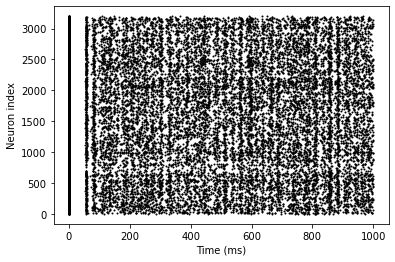

In [4]:
# instantiate EINet
net = EINet()
# initialize DSRunner
runner = bp.DSRunner(target=net,
                     monitors=['E.spike'],
                     inputs=[('E.input', 20.), ('I.input', 20.)],
                     jit=True)
# run the simulation
runner.run(duration=1000.)
bp.visualize.raster_plot(runner.mon.ts, runner.mon['E.spike'])

We have run a simple example of using `DSRunner`, but there are many advanced usages despite this. Next we will formally introduce two main aspects that will be used frequently in `DSRunner`: monitors and inputs.

## Monitors in DSRunner

In BrainPy, any instance of ``brainpy.dyn.DSRunner`` has a built-in monitor. Users can set up a monitor when initializing a runner. There are multiple methods to initialize a monitor. The first method is to initialize a monitor is through a list of strings.

### Initialization with a list of strings

In [5]:
# initialize monitor through a list of strings
runner1 = bp.DSRunner(target=net,
                      monitors=['E.spike', 'E.V', 'I.spike', 'I.V'],  # 4 elements in monitors
                      inputs=[('E.input', 20.), ('I.input', 20.)],
                      jit=True)

where all the strings corresponds to the name of the variables in the EI network:

In [6]:
net.E.V, net.E.spike

(Variable([-54.15917 , -57.344418, -53.688225, ..., -61.752525, -55.393806,
           -57.100418], dtype=float32),
 Variable([False, False, False, ..., False, False, False], dtype=bool))

Once we call the runner with a given time duration, the monitor will automatically record the variable evolutions in the corresponding models. Afterwards, users can access these variable trajectories by using .mon.[variable_name]. The default history times .mon.ts will also be generated after the model finishes its running. Let’s see an example.


  0%|          | 0/1000 [00:00<?, ?it/s]

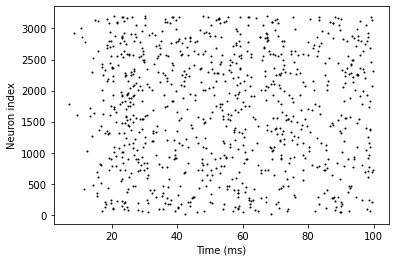

In [7]:
runner1.run(100.)
bp.visualize.raster_plot(runner1.mon.ts, runner1.mon['E.spike'], show=True)

### Initialization with index specification

The second method is similar to the first one, with the difference that the index specification is added. Index specification means users only monitor the specific neurons and ignore all the other neurons. Sometimes we do not care about all the contents in a variable. We may be only interested in the values at the certain indices. Moreover, for a huge network with a long-time simulation, monitors will consume a large part of RAM. Therefore, monitoring variables only at the selected indices will be more applicable. BrainPy supports monitoring a part of elements in a Variable with the format of tuple like this:

In [8]:
# initialize monitor through a list of strings with index specification
runner2 = bp.DSRunner(target=net,
                      monitors=[('E.spike', [1, 2, 3]),  # monitor values of Variable at index of [1, 2, 3]
                                'E.V'],  # monitor all values of Variable 'V'
                      inputs=[('E.input', 20.), ('I.input', 20.)],
                      jit=True)
runner2.run(100.)
print('The monitor shape of "E.V" is (run length, variable size) = {}'.format(runner2.mon['E.V'].shape))
print('The monitor shape of "E.spike" is (run length, index size) = {}'.format(runner2.mon['E.spike'].shape))

  0%|          | 0/1000 [00:00<?, ?it/s]

The monitor shape of "E.V" is (run length, variable size) = (1000, 3200)
The monitor shape of "E.spike" is (run length, index size) = (1000, 3)


### Explicit monitor target

The third method is to use a dict with the explicit monitor target. Users can access model instance and get certain variables as monitor target:

In [9]:
# initialize monitor through a dict with the explicit monitor target
runner3 = bp.DSRunner(target=net,
                      monitors={'spike': net.E.spike, 'V': net.E.V},
                      inputs=[('E.input', 20.), ('I.input', 20.)],
                      jit=True)
runner3.run(100.)
print('The monitor shape of "V" is = {}'.format(runner3.mon['V'].shape))
print('The monitor shape of "spike" is = {}'.format(runner3.mon['spike'].shape))

  0%|          | 0/1000 [00:00<?, ?it/s]

The monitor shape of "V" is = (1000, 3200)
The monitor shape of "spike" is = (1000, 3200)


### Explicit monitor target with index specification

The fourth method is similar to the third one, with the difference that the index specification is added:

In [10]:
# initialize monitor through a dict with the explicit monitor target
runner4 = bp.DSRunner(target=net,
                      monitors={'E.spike': (net.E.spike, [1, 2]),  # monitor values of Variable at index of [1, 2]
                                'E.V': net.E.V},  # monitor all values of Variable 'V'
                      inputs=[('E.input', 20.), ('I.input', 20.)],
                      jit=True)
runner4.run(100.)
print('The monitor shape of "E.V" is = {}'.format(runner4.mon['E.V'].shape))
print('The monitor shape of "E.spike" is = {}'.format(runner4.mon['E.spike'].shape))

  0%|          | 0/1000 [00:00<?, ?it/s]

The monitor shape of "E.V" is = (1000, 3200)
The monitor shape of "E.spike" is = (1000, 2)


In spite of the four methods mentioned above, BrainPy also provides users a convenient parameter to monitor more complicate variables: `fun_monitor`. Users can use a function to describe monitor and pass to `fun_monitor`. `fun_monitor` must be a dict and the `key` should be a string for the later retrieval by `runner.mon[key]`, the `value` should be a callable function which receives an arguments: `tdi`. The format of `fun_monitor` is shown as below:
```python
fun_monitor = {'key_name': lambda tdi: body_func(tdi)}
```

Here we monitor a variable that

  0%|          | 0/1000 [00:00<?, ?it/s]

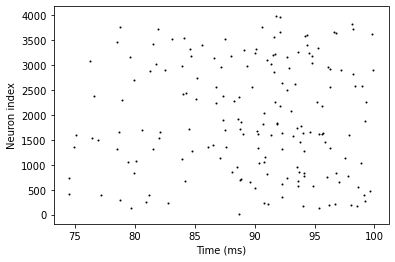

In [11]:
runner5 = bp.DSRunner(target=net,
                      fun_monitors={'E-I.spike': lambda tdi: bm.concatenate((net.E.spike, net.I.spike), axis=0)},
                      inputs=[('E.input', 20.), ('I.input', 20.)],
                      jit=True)
runner5.run(100.)
bp.visualize.raster_plot(runner5.mon.ts, runner5.mon['E-I.spike'])

## Inputs in DSRunner

In brain dynamics simulation, various inputs are usually given to different units of the dynamical system. In BrainPy, `inputs` can be specified to runners for dynamical systems. The aim of ``inputs`` is to mimic the input operations in experiments like Transcranial Magnetic Stimulation (TMS) and patch clamp recording.

``inputs`` should have the format like ``(target, value, [type, operation])``, where
- ``target`` is the target variable to inject the input.
- ``value`` is the input value. It can be a scalar, a tensor, or a iterable object/function.
- ``type`` is the type of the input value. It support two types of input: ``fix`` and ``iter``. The first one means that the data is static; the second one denotes the data can be iterable, no matter whether the input value is a tensor or a function. The `iter` type must be explicitly stated.
- ``operation`` is the input operation on the target variable. It should be set as one of `{ + , - , * , / , = }`, and if users do not provide this item explicitly, it will be set to '+' by default, which means that the target variable will be updated as ``val = val + input``.

Users can also give multiple inputs for different target variables, like:

```python

inputs=[(target1, value1, [type1, op1]),
        (target2, value2, [type2, op2]),
              ... ]
```

### Static inputs

The first example is providing static inputs. The excitation and inhibition neurons all receive the same current intensity:

  0%|          | 0/1000 [00:00<?, ?it/s]

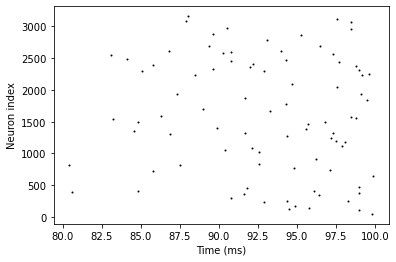

In [12]:
runner6 = bp.DSRunner(target=net,
                      monitors=['E.spike'],
                      inputs=[('E.input', 20.), ('I.input', 20.)],  # static inputs
                      jit=True)
runner6.run(100.)
bp.visualize.raster_plot(runner6.mon.ts, runner6.mon['E.spike'])

### Iterable inputs

The second example is providing iterable inputs. Users need to set `type=iter` and pass an iterable object or function into `value`:

  0%|          | 0/12000 [00:00<?, ?it/s]

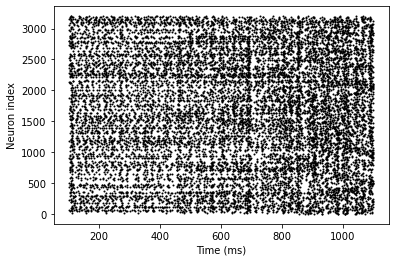

In [13]:
I, length = bp.inputs.section_input(values=[0, 20., 0],
                                    durations=[100, 1000, 100],
                                    return_length=True,
                                    dt=0.1)

runner7 = bp.DSRunner(target=net,
                      monitors=['E.spike'],
                      inputs=[('E.input', I, 'iter'), ('I.input', I, 'iter')],  # iterable inputs
                      jit=True)
runner7.run(length)
bp.visualize.raster_plot(runner7.mon.ts, runner7.mon['E.spike'])

By examples given above, users can easily understand the usage of inputs parameters. Similar to monitors, inputs can also be more complicate as a function form. BrainPy provides `fun_inputs` to receive the customized functional inputs created by users.

  0%|          | 0/1000 [00:00<?, ?it/s]

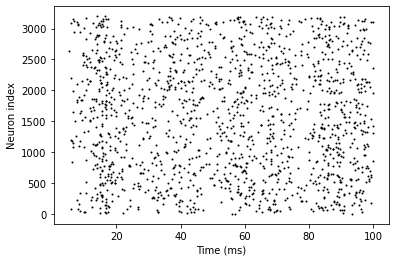

In [18]:
def set_input(tdi):
  net.E.input[:] = 20
  net.I.input[:] = 20.


runner8 = bp.DSRunner(target=net,
                      monitors=['E.spike'],
                      fun_inputs=set_input,  # functional inputs
                      jit=True)
runner8.run(200.)
bp.visualize.raster_plot(runner8.mon.ts, runner8.mon['E.spike'])